In [1]:
import torch
import numpy as np
from torch import optim
import os
import matplotlib.pyplot as plt

In [2]:
from dlem import util
from dlem import load_model, load_reader

In [3]:
NUMBER_OF_CHANNELS_PER_ROUTE = 3

In [4]:
BATCH_SIZE =  64
DATA_FOLDER = "../../../loopextrusion_data_creation/.data/akita_data_w_seqindx_res_10k_ps_120"
TEST_FOLD = 'fold4'
VAL_FOLD = 'fold5'
LEARNING_RATE = 0.0001
PATIENCE = 25
NUM_EPOCH = 5#250
SAVE_FOLDER = "results_w_new_seqindx_res_10k_ps_120"

In [5]:
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
data = load_reader("datareader_w_seq_memmap_index")(DATA_FOLDER, sub_select=np.array([1])) # Selecting ctcf and dnase

In [7]:
data.args

{'RES': 10000,
 'PATCH_SIZE': 120,
 'BW_FILES': ['H1_CTCF_ENCFF038RVZ.bigWig', 'H1_DNAse_ENCFF232GUZ.bigWig'],
 'SEQ_FEA_FILES': ['sequence_features_pos_10000.tsv',
  'sequence_features_neg_10000.tsv'],
 'START_DIAG': 3,
 'STOP_DIAG': 80,
 'PATCH_DIM': 120,
 'PATCH_LEN': 6083,
 'FEA_DIM': 4,
 'REGION_FILE': 'sequences.bed',
 'COOLER_FILE': '4DNFI9GMP2J8.mcool',
 'SAMPLE_NUM': 5841,
 'SEQUENCE_OFFSET': 1000,
 'GENOME_FILE': 'hg38'}

In [8]:
def weighted_mse(pred, target):
    return torch.mean((pred - target)**2*torch.exp(target))

In [9]:
weighted_mse(data[0][0], data[1][0])

tensor(0.6736)

In [10]:
data_test = torch.utils.data.Subset(data, np.where(data.data_folds == TEST_FOLD)[0])
data_val = torch.utils.data.Subset(data, np.where(data.data_folds == VAL_FOLD)[0])
data_train = torch.utils.data.Subset(data, np.where(np.logical_and(data.data_folds != VAL_FOLD,
                                                                   data.data_folds != TEST_FOLD))[0])

In [11]:
dataloader_test = torch.utils.data.DataLoader(data_test, batch_size = BATCH_SIZE, shuffle=True)
dataloader_val = torch.utils.data.DataLoader(data_val, batch_size = BATCH_SIZE, shuffle=True)
dataloader_train = torch.utils.data.DataLoader(data_train, batch_size = BATCH_SIZE, shuffle=True)

In [12]:
index_diagonal = util.diag_index_for_mat(data.patch_dim, data.start_diag, data.stop_diag)

In [13]:
model = load_model("encodetocontact_forked_seq_lite")(data.patch_dim,
                                                      data.feature_dim,
                                                      data.start_diag,
                                                      data.stop_diag,
                                                      seq_fea_dim=32,
                                                      hidden_dim=32,
                                                      channel_per_route=NUMBER_OF_CHANNELS_PER_ROUTE)
model = model.to(dev)

In [14]:
model

DLEM(
  (seq_pooler): SequencePoolerInterleaved(
    (pooler): Sequential(
      (0): InterleavedConv1d(
        (left_conv): Conv1d(4, 16, kernel_size=(5,), stride=(10,), dilation=(2,))
        (right_conv): Conv1d(4, 16, kernel_size=(5,), stride=(10,), dilation=(2,))
      )
      (1): Conv1dResidualBlock(
        (res): Sequential(
          (0): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (1): ReLU()
          (2): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
          (3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (4): ReLU()
          (5): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
        )
      )
      (2): InterleavedConv1d(
        (left_conv): Conv1d(32, 16, kernel_size=(5,), stride=(10,), dilation=(2,))
        (right_conv): Conv1d(32, 16, kernel_size=(5,), stride=(10,), dilation=(2,))
      )
      (3): Conv1dResidualB

In [15]:
if not os.path.exists(os.path.join(DATA_FOLDER, SAVE_FOLDER)):
    os.mkdir(os.path.join(DATA_FOLDER, SAVE_FOLDER))

In [16]:
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=PATIENCE, mode='max')
loss = torch.nn.MSELoss(reduction='sum')
#loss = weighted_mse

In [17]:
diag_init = torch.from_numpy(np.ones((BATCH_SIZE, data.patch_dim - data.start_diag), dtype=np.float32) * data.patch_dim)

In [18]:
lr_threshold = 1.5e-6

In [19]:
import time

In [20]:
best_loss = torch.inf
best_corr = -1
mean_loss_traj_train = []
mean_corr_traj_val = []
read_times = []
inner_times = []
model = model.to(dev)
diag_init = diag_init.to(dev)
for e in range(NUM_EPOCH):
    training_loss = []
    validation_corr = []
    model.train()
    end = time.time()
    for diagonals, tracks, seq in dataloader_train:
        start = time.time()
        read_times.append(start-end)
        optimizer.zero_grad()
        out = model(diagonals, tracks, seq)
        total_loss = loss(out, diagonals[:, index_diagonal(data.start_diag)[-1]+1:])
        total_loss.backward()
        optimizer.step()
        training_loss.append(total_loss.detach().cpu().numpy())
        end = time.time()
        inner_times.append(end-start)

    mean_total_loss = np.mean(training_loss)
    mean_loss_traj_train.append(mean_total_loss)

    if mean_total_loss < best_loss:
        best_loss = mean_total_loss
        torch.save(model.state_dict(),
                   os.path.join(DATA_FOLDER, SAVE_FOLDER, "best_loss.pt"))

    with torch.no_grad():
        model.eval()

        #end = time.time()
        for diagonals, tracks, seq in dataloader_val:
            #start = time.time()
            #print(f'{e}: read val: {start-end}')
            out = model.contact_map_prediction(tracks,
                                               seq,
                                               diag_init[:tracks.shape[0]])
            validation_corr.append(util.vec_corr_batch(
                diagonals[:, index_diagonal(data.start_diag)[-1]+1:],
                out
            ).detach().cpu().numpy())
            #end = time.time()
            #print(f'{e}: inner val: {end-start}')

        mean_corr = np.mean(validation_corr)
        mean_corr_traj_val.append(mean_corr)

    if mean_corr > best_corr:
        best_corr = mean_corr
        torch.save(model.state_dict(),
                   os.path.join(DATA_FOLDER, SAVE_FOLDER, "best_correlation.pt"))

    scheduler.step(mean_corr)
    if scheduler.get_last_lr()[-1] < lr_threshold:
        break

    print(f'{int((e+1)/NUM_EPOCH*100):3}/100: '
            f'correlation = {mean_corr:.3f}, '
            f'loss = {mean_total_loss:.3f}',
            flush=True, end='\r')
    np.save(os.path.join(DATA_FOLDER, SAVE_FOLDER, "mean_loss_traj_train.npy"),
            mean_loss_traj_train)
    np.save(os.path.join(DATA_FOLDER, SAVE_FOLDER, "mean_corr_traj_val.npy"),
            mean_corr_traj_val)

In [ ]:
diagonals, tracks, seq = data[0] 
out = model(diagonals.unsqueeze(0), tracks.unsqueeze(0), seq.unsqueeze(0))
out_complete_pred = model.contact_map_prediction(tracks.unsqueeze(0), seq.unsqueeze(0), diag_init[:1])

/data/src/loopextrusion_pytorch/.conda/lib/python3.11/site-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,


In [ ]:
patch = util.convert_diags_to_full_contact(diagonals.numpy(), data.start_diag, data.stop_diag)
patch_prediction = util.convert_diags_to_full_contact(out[0].detach().numpy(), data.start_diag+1, data.stop_diag)
patch_prediction_complete = util.convert_diags_to_full_contact(out_complete_pred[0].detach().numpy(), data.start_diag+1, data.stop_diag)

In [ ]:
left_right = model.converter(tracks.unsqueeze(0).to(dev), seq.unsqueeze(0).to(dev))

In [ ]:
left_right.shape

torch.Size([1, 2, 120])

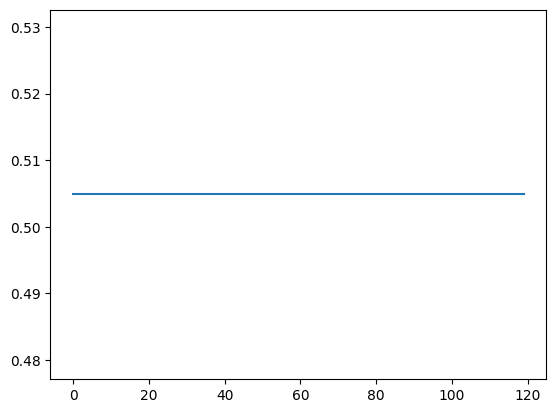

In [ ]:
plt.plot(left_right[0, 0, :].detach().cpu().numpy())

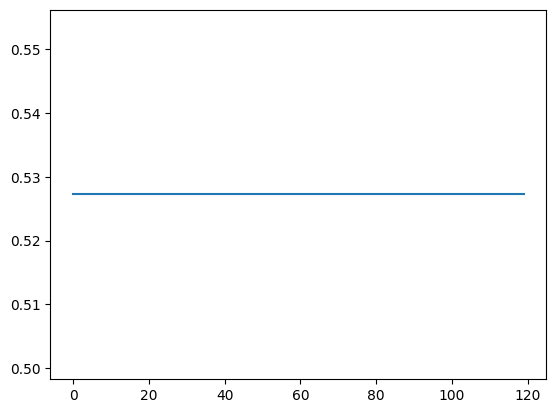

In [ ]:
plt.plot(left_right[0, 1, :].detach().cpu().numpy())

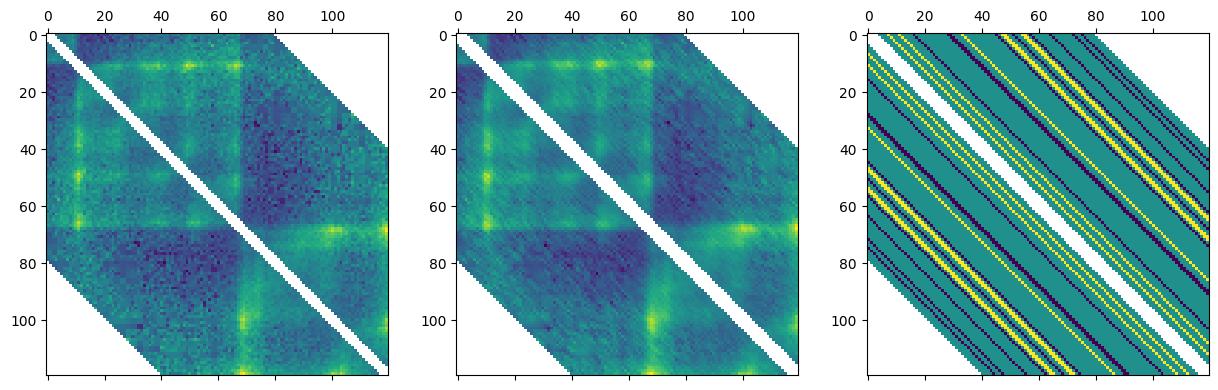

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].matshow(patch, cmap='viridis')
axes[1].matshow(patch_prediction, cmap='viridis')
axes[2].matshow(patch_prediction_complete, cmap='viridis')

In [ ]:
scheduler.get_last_lr()

[0.0001]

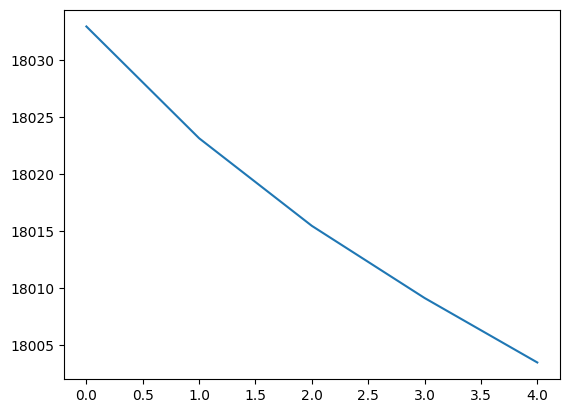

In [ ]:
plt.plot(mean_loss_traj_train)

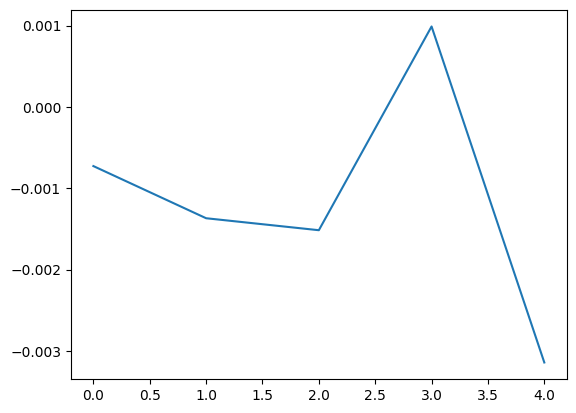

In [ ]:
plt.plot(mean_corr_traj_val)

In [ ]:
np.mean(read_times)

0.756822156906128

In [ ]:
np.mean(inner_times)

0.445608115196228